In [3]:
import os

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scportrait.pipeline.classification import CellFeaturizer
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import CytosolSegmentationCellpose
from scportrait.pipeline.selection import LMDSelection

In [4]:
project_location = "project"

project = Project(
    os.path.abspath(project_location),
    config_path="config_example2.yml",
    overwrite=True,
    debug=True,
    segmentation_f=CytosolSegmentationCellpose,
    extraction_f=HDF5CellExtraction,
    classification_f=CellFeaturizer,
    selection_f=LMDSelection,
)

Updating project config file.
[28/10/2024 10:18:32] Loading config from /Users/altananamsaraeva/Packages/scPortrait/example_data/example_2/project/config.yml
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/altananamsaraeva/Packages/scPortrait/example_data/example_2/project/scportrait.sdata               
[28/10/2024 10:18:32] No cache directory specified in config using current working directory /Users/altananamsaraeva/Packages/scPortrait/example_data/example_2.
[28/10/2024 10:18:32] No cache directory specified in config using current working directory /Users/altananamsaraeva/Packages/scPortrait/example_data/example_2.


In [5]:
from scportrait.data._datasets import dataset_2

dataset_2_path = dataset_2()

# these example images are downloaded from the human protein atlas (www.proteinatlas.org)
images = [f"{dataset_2_path}/Ch1.tif", f"{dataset_2_path}/Ch2.tif", f"{dataset_2_path }/Ch3.tif"]

project.load_input_from_tif_files(images)

Downloading...: 100%|██████████| 135k/135k [00:00<00:00, 1.12MB/s]

[28/10/2024 10:19:08] Output location /Users/altananamsaraeva/Packages/scPortrait/example_data/example_2/project/scportrait.sdata already exists. Overwriting.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/altananamsaraeva/Packages/scPortrait/example_data/example_2/project/scportrait.sdata               


[28/10/2024 10:19:08] Initialized temporary directory at /Users/altananamsaraeva/Packages/scPortrait/example_data/example_2/Project_srorv5xr for Project
[28/10/2024 10:19:08] Image input_image written to sdata object.
[28/10/2024 10:19:08] Cleaned up temporary directory at <TemporaryDirectory '/Users/altananamsaraeva/Packages/scPortrait/example_data/example_2/Project_srorv5xr'>


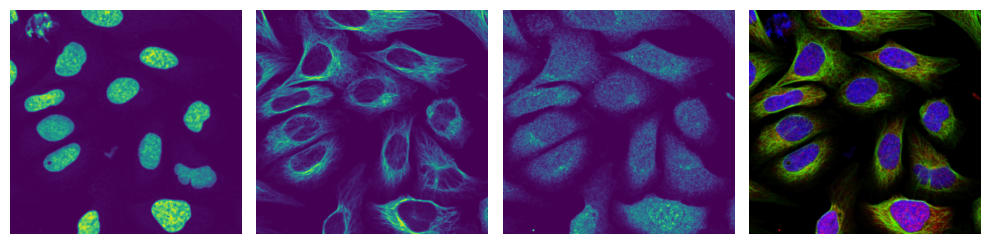

In [6]:
# visualize input images as example
# it is not recommended to execute this block with large input images as it will compute for some time


def colorize(im, color, clip_percentile=0.0):
    """
    Helper function to create an RGB image from a single-channel image using a
    specific color.
    """
    # Check that we do just have a 2D image
    if im.ndim > 2 and im.shape[2] != 1:
        raise ValueError("This function expects a single-channel image!")

    # Rescale the image according to how we want to display it
    im_scaled = im.astype(np.float32) - np.percentile(im, clip_percentile)
    im_scaled = im_scaled / np.percentile(im_scaled, 100 - clip_percentile)
    im_scaled = np.clip(im_scaled, 0, 1)

    # Need to make sure we have a channels dimension for the multiplication to work
    im_scaled = np.atleast_3d(im_scaled)

    # Reshape the color (here, we assume channels last)
    color = np.asarray(color).reshape((1, 1, -1))
    return im_scaled * color


def generate_composite(images, colors=None, plot=False):
    if colors is None:
        colors = [(0, 0, 1), (0, 1, 0), (1, 0, 0), (1, 0, 1)]
    colorized = []
    for image, color in zip(images, colors, strict=False):
        image = colorize(image, color, 0.0)
        colorized.append(image)

    if plot:
        for i in colorized:
            plt.figure()
            plt.imshow(i)

    image = colorized[0]
    for i in range(len(colorized) - 1):
        image += colorized[i + 1]

    return np.clip(image, 0, 1)


fig, axs = plt.subplots(1, 4, figsize=(10, 4))
axs[0].imshow(project.input_image[0])
axs[0].axis("off")

axs[1].imshow(project.input_image[1])
axs[1].axis("off")

axs[2].imshow(project.input_image[2])
axs[2].axis("off")

img = generate_composite(project.input_image)

axs[3].imshow(img)
axs[3].axis("off")

fig.tight_layout()

[28/10/2024 10:19:26] Initialized temporary directory at /var/folders/77/2xx95bp15r75btdlpffs_cnw0000gn/T/./CytosolSegmentationCellpose_971m5oa3 for CytosolSegmentationCellpose
[28/10/2024 10:19:26] GPU Status for segmentation is True and will segment using the following device mps.


/Users/altananamsaraeva/miniconda3/envs/scportrait/lib/python3.10/site-packages/cellpose/resnet_torch.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torc

[28/10/2024 10:19:26] Segmenting nucleus using the following model: nuclei


/Users/altananamsaraeva/miniconda3/envs/scportrait/lib/python3.10/site-packages/cellpose/dynamics.py:189: RuntimeWarning: invalid value encountered in divide
  mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)
/Users/altananamsaraeva/miniconda3/envs/scportrait/lib/python3.10/site-packages/cellpose/resnet_torch.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start s

[28/10/2024 10:19:30] Segmenting cytosol using the following model: cyto2


/Users/altananamsaraeva/miniconda3/envs/scportrait/lib/python3.10/site-packages/cellpose/dynamics.py:189: RuntimeWarning: invalid value encountered in divide
  mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)
/Users/altananamsaraeva/miniconda3/envs/scportrait/lib/python3.10/site-packages/cellpose/dynamics.py:189: RuntimeWarning: invalid value encountered in divide
  mu /= (1e-60 + (mu**2).sum(axis=0)**0.5)


[28/10/2024 10:19:31] Performing filtering to match Cytosol and Nucleus IDs.
[28/10/2024 10:19:31] Removed 4 nuclei and 3 cytosols due to filtering.
[28/10/2024 10:19:31] After filtering, 7 matching nuclei and cytosol masks remain.
[28/10/2024 10:19:32] Total time to perform nucleus and cytosol mask matching filtering: 0.94 seconds
[28/10/2024 10:19:33] Segmentation seg_all_nucleus written to sdata object.
[28/10/2024 10:19:33] Segmentation seg_all_cytosol written to sdata object.
[28/10/2024 10:19:33] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/77/2xx95bp15r75btdlpffs_cnw0000gn/T/./CytosolSegmentationCellpose_971m5oa3'>


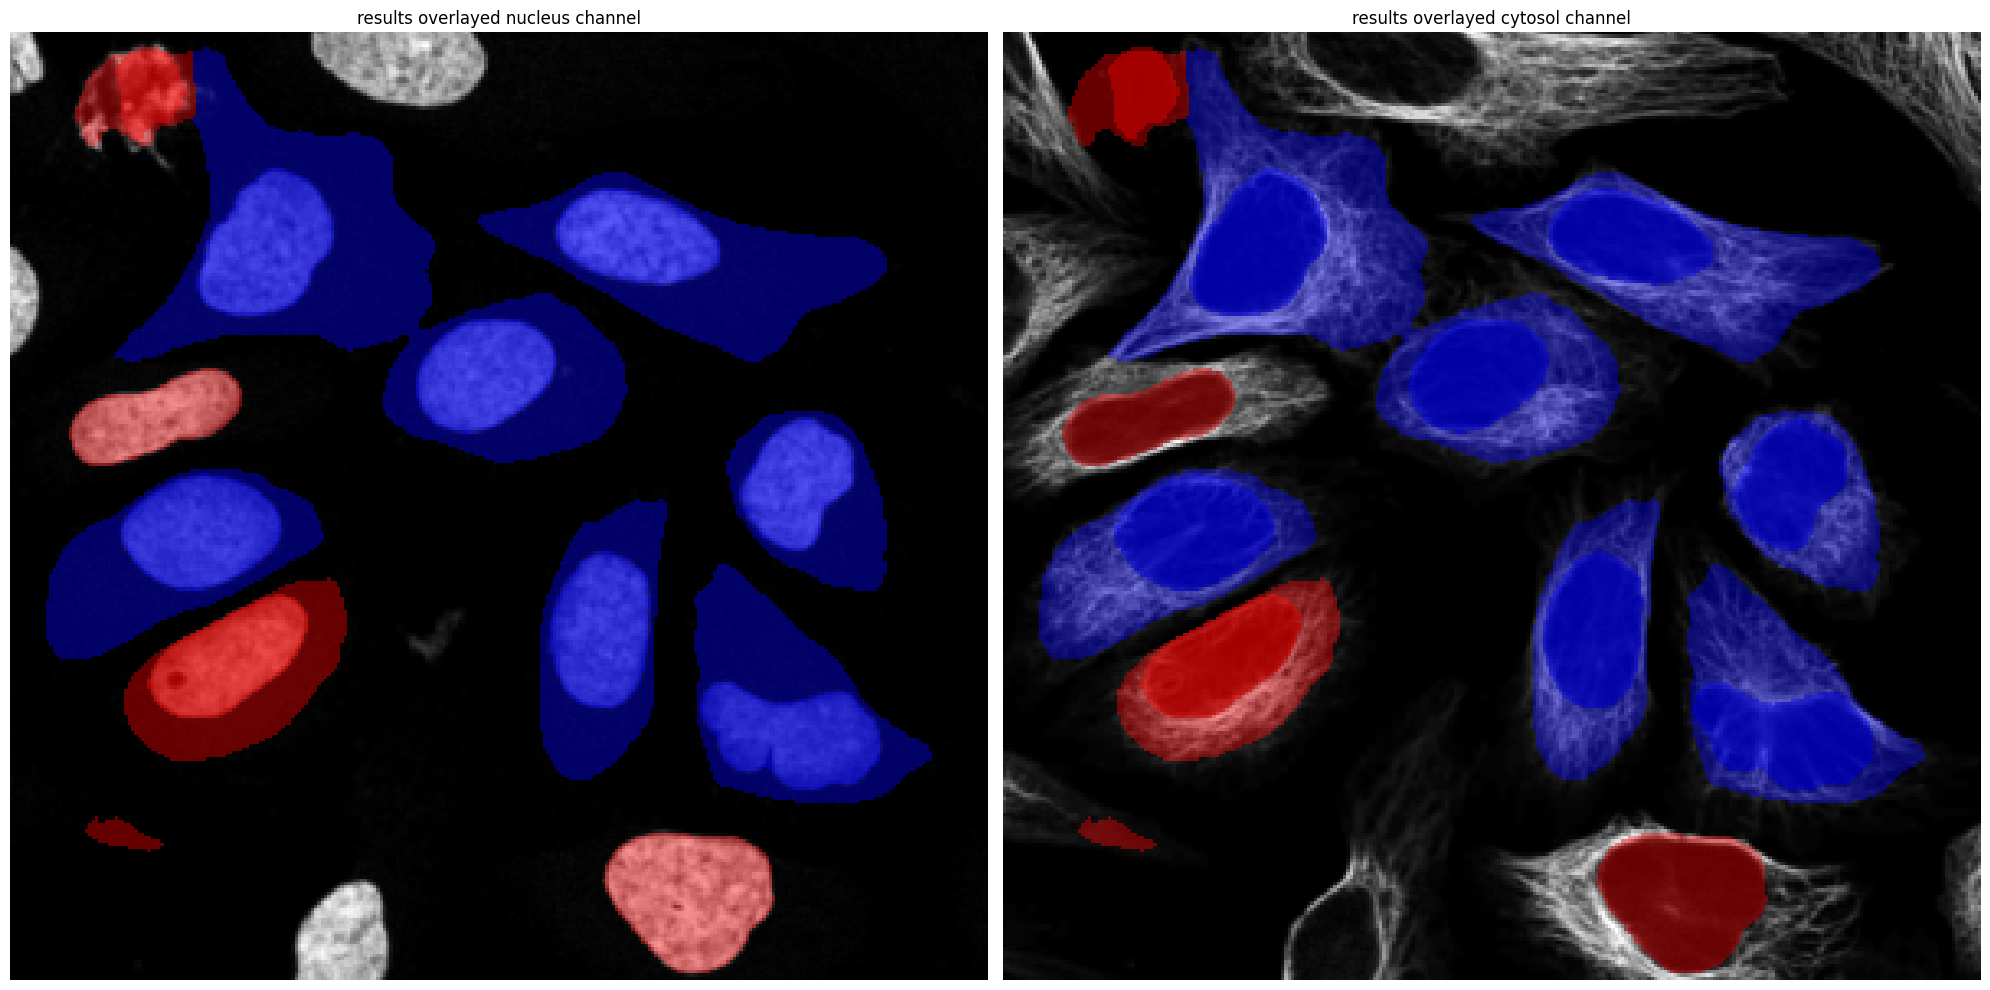

In [7]:
project.segment()

(-0.5, 298.5, 289.5, -0.5)

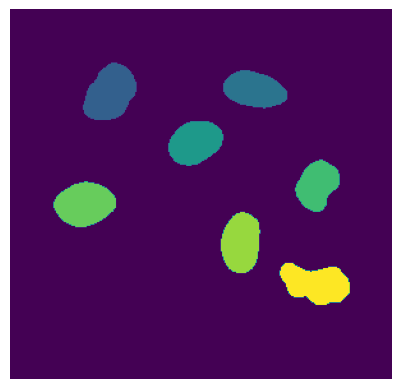

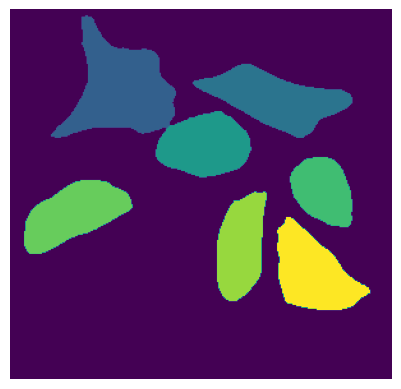

In [8]:
plt.figure()
plt.imshow(project.sdata["seg_all_nucleus"])
plt.axis("off")

plt.figure()
plt.imshow(project.sdata["seg_all_cytosol"])
plt.axis("off")

In [9]:
project.view_sdata()

In [10]:
project.extract()

[28/10/2024 10:19:43] Initialized temporary directory at /var/folders/77/2xx95bp15r75btdlpffs_cnw0000gn/T/./HDF5CellExtraction_c9p00v58 for HDF5CellExtraction
[28/10/2024 10:19:43] Created new directory for extraction results: /Users/altananamsaraeva/Packages/scPortrait/example_data/example_2/project/extraction/data
[28/10/2024 10:19:43] Setup output folder at /Users/altananamsaraeva/Packages/scPortrait/example_data/example_2/project/extraction/data
[28/10/2024 10:19:43] Found 2 segmentation masks for the given key in the sdata object. Will be extracting single-cell images based on these masks: ['seg_all_nucleus', 'seg_all_cytosol']
[28/10/2024 10:19:43] Using seg_all_nucleus as the main segmentation mask to determine cell centers.
[28/10/2024 10:19:45] Points centers_cells written to sdata object.
[28/10/2024 10:19:45] Extraction Details:
[28/10/2024 10:19:45] --------------------------------
[28/10/2024 10:19:45] Number of input image channels: 3
[28/10/2024 10:19:45] Number of segme

Processing cell batches: 100%|██████████| 1/1 [00:00<00:00, 21.84it/s]

multiprocessing done.
[28/10/2024 10:19:46] Finished extraction in 0.11 seconds (66.31 cells / second)
[28/10/2024 10:19:46] Transferring results to final HDF5 data container.
[28/10/2024 10:19:46] number of cells too close to image edges to extract: 0
[28/10/2024 10:19:46] A total of 0 cells were too close to the image border to be extracted. Their cell_ids were saved to file /Users/altananamsaraeva/Packages/scPortrait/example_data/example_2/project/segmentation/removed_classes.csv.
[28/10/2024 10:19:46] Transferring extracted single cells to .hdf5
[28/10/2024 10:19:46] single-cell index created.


[28/10/2024 10:19:46] single-cell data created
[28/10/2024 10:19:46] single-cell index labelled created.
[28/10/2024 10:19:46] channel information created.
[28/10/2024 10:19:47] Benchmarking times saved to file.
[28/10/2024 10:19:47] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/77/2xx95bp15r75btdlpffs_cnw0000gn/T/./HDF5CellExtraction_c9p00v58'>


(7, 5, 110, 110)


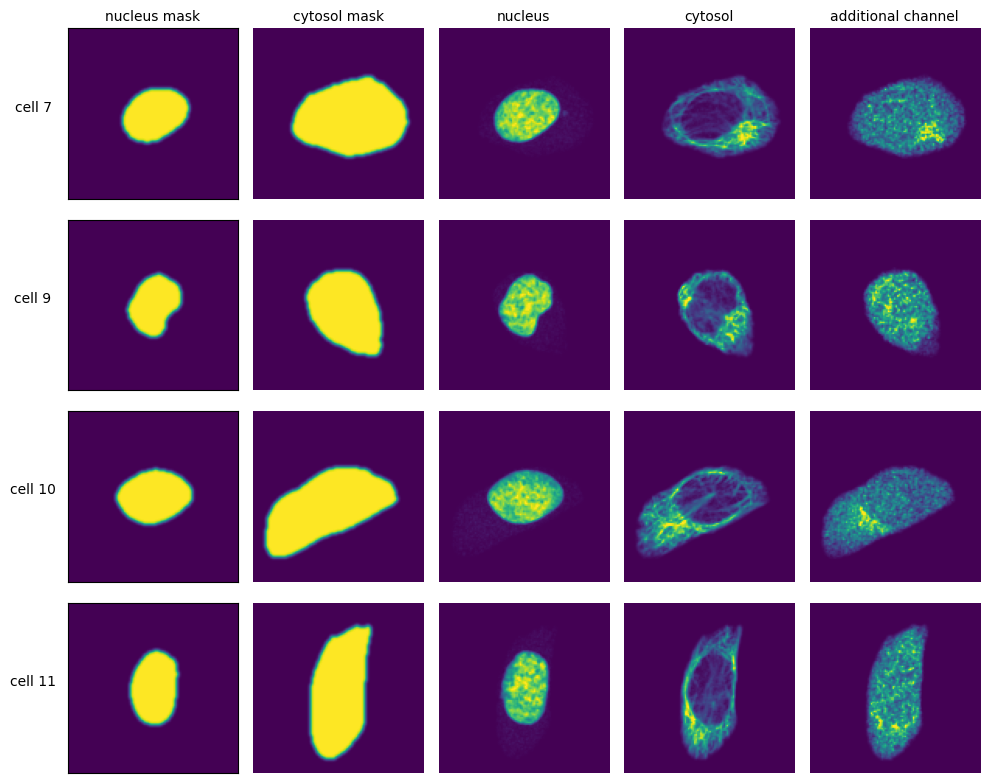

In [11]:
with h5py.File(f"{project_location}/extraction/data/single_cells.h5") as hf:
    index = hf.get("single_cell_index")
    images = hf.get("single_cell_data")

    print(images.shape)

    n_cells = [2, 3, 4, 5]
    fig, axs = plt.subplots(len(n_cells), 5, figsize=(5 * 2, len(n_cells) * 2))
    labels = ["nucleus mask", "cytosol mask", "nucleus", "cytosol", "additional channel"]

    for i, id in enumerate(n_cells):
        cell_id = index[id][1]
        image = images[id]

        for n, _img in enumerate(image):
            axs[i, n].imshow(_img)

            if n == 0:
                axs[i, n].set_ylabel(f"cell {cell_id}", fontsize=10, rotation=0, labelpad=25)
                axs[i, n].xaxis.set_visible(False)
                axs[i, n].tick_params(left=False, labelleft=False)
            else:
                axs[i, n].axis("off")

            if i == 0:
                axs[i, n].set_title(labels[n], fontsize=10)

    fig.tight_layout()

In [12]:
project.classify()

Using extraction directory: /Users/altananamsaraeva/Packages/scPortrait/example_data/example_2/project/extraction/data/single_cells.h5
[28/10/2024 10:20:07] Initialized temporary directory at /Users/altananamsaraeva/Packages/scPortrait/example_data/example_2/CellFeaturizer_x9r847wn for CellFeaturizer
[28/10/2024 10:20:07] Started CellFeaturization of all available channels.
[28/10/2024 10:20:07] Created new directory for classification results: /Users/altananamsaraeva/Packages/scPortrait/example_data/example_2/project/classification/complete_CellFeaturizer
[28/10/2024 10:20:07] CPU specified in config file but MPS available on system. Consider changing the device for the next run.
[28/10/2024 10:20:07] Reading data from path: /Users/altananamsaraeva/Packages/scPortrait/example_data/example_2/project/extraction/data/single_cells.h5
[28/10/2024 10:20:07] Dataloader generated with a batchsize of 900 and 0 workers. Dataloader contains 1 entries.
[28/10/2024 10:20:07] Started processing of 

In [13]:
# load classification results
results = pd.read_csv(f"{project_location}/classification/complete_CellFeaturizer/calculated_image_features.csv")
results

,nucleus_area,cytosol_area,cytosol_only_area,1_mean_nucleus,1_median_nucleus,1_quant75_nucleus,1_quant25_nucleus,1_summed_intensity_nucleus,1_summed_intensity_area_normalized_nucleus,1_mean_cytosol,...,3_summed_intensity_cytosol,3_summed_intensity_area_normalized_cytosol,3_mean_cytosol_only,3_median_cytosol_only,3_quant75_cytosol_only,3_quant25_cytosol_only,3_summed_intensity_cytosol_only,3_summed_intensity_area_normalized_cytosol_only,label,cell_id
0,2043.0,6255.0,4212.0,0.083599,0.0,0.022018,0.0,1011.54810,0.240159,0.083599,...,1493.5212,0.354587,0.123432,0.0,0.222168,0.0,1493.5212,0.354587,0,4
1,1746.0,4319.0,2573.0,0.065944,0.0,0.006208,0.0,797.92487,0.310115,0.065944,...,1314.1406,0.510743,0.108607,0.0,0.089417,0.0,1314.1406,0.510743,0,5
2,1768.0,3839.0,2071.0,0.072416,0.0,0.001513,0.0,876.22960,0.423095,0.072416,...,1079.3033,0.521151,0.089199,0.0,0.021355,0.0,1079.3033,0.521151,0,7
3,1586.0,2841.0,1255.0,0.060929,0.0,0.000000,0.0,737.24255,0.587444,0.060929,...,897.2368,0.714930,0.074152,0.0,0.000000,0.0,897.2368,0.714930,0,9
4,1972.0,4059.0,2087.0,0.077522,0.0,0.003454,0.0,938.01587,0.449457,0.077522,...,1034.5684,0.495720,0.085502,0.0,0.036766,0.0,1034.5684,0.495720,0,10
5,1820.0,3528.0,1708.0,0.068512,0.0,0.000009,0.0,828.99084,0.485358,0.068512,...,1114.2695,0.652383,0.092088,0.0,0.000152,0.0,1114.2695,0.652383,0,11
6,2014.0,4259.0,2245.0,0.070969,0.0,0.007248,0.0,858.72720,0.382507,0.070969,...,1082.3153,0.482100,0.089448,0.0,0.091553,0.0,1082.3153,0.482100,0,13
